Starting Simulation M=8 on 20 cores...


100%|███████████████████████████████| 1000000/1000000 [6:30:52<00:00, 42.64it/s]



Simulation finished in 23452.86s
Valid Models Found: 999970 (100.0%)


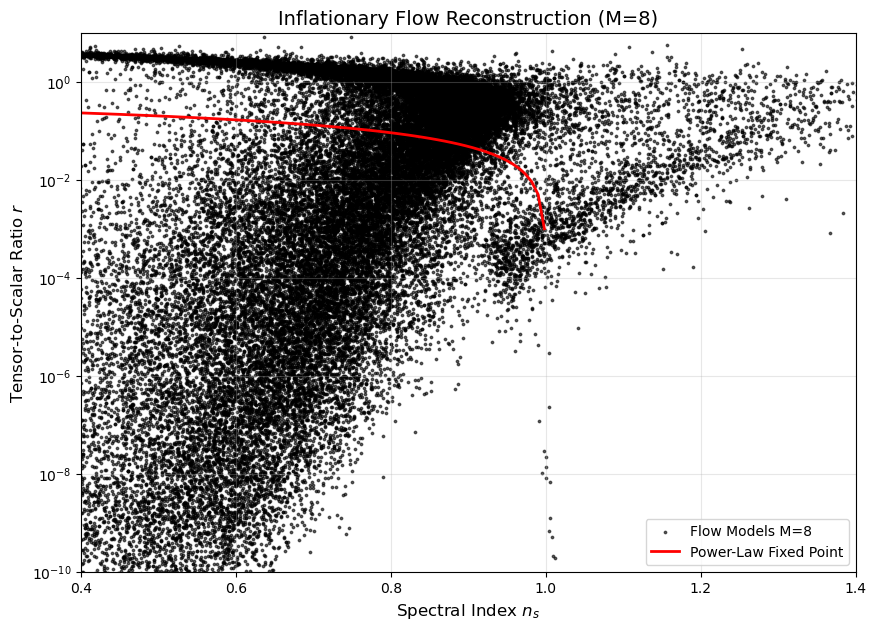

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import time

# --- Configuration ---
NUM_CORES = 20          
NUM_SIMULATIONS = 1000000
M_ORDER = 8            # Set to 8 for Chen et al. replication

# --- Constants ---
C_CONST = 4 * (np.log(2) + 0.5772156649) - 5 

def get_initial_conditions(m_order):
    """
    Generates random initial conditions.
    Ranges shrink by factor of 10 for each higher order (Kinney 2002).
    """
    y = np.zeros(m_order + 1)
    y[0] = np.random.uniform(0, 0.8)   # epsilon
    y[1] = np.random.uniform(-0.5, 0.5) # sigma
    
    current_range = 0.05
    for l in range(2, m_order + 1):
        y[l] = np.random.uniform(-current_range, current_range)
        current_range /= 10.0
    return y

def flow_derivatives(t, y, m_order):
    """
    The Inflationary Flow Equations (autonomous, so t is unused but required by solver).
    """
    epsilon = y[0]
    sigma = y[1]
    lambdas = y[2:]
    
    dydN = np.zeros_like(y)
    
    # 1. d(epsilon)/dN
    dydN[0] = epsilon * (sigma + 2 * epsilon)
    
    # 2. d(sigma)/dN
    lambda2 = lambdas[0] if len(lambdas) > 0 else 0
    dydN[1] = -5 * epsilon * sigma - 12 * (epsilon**2) + 2 * lambda2
    
    # 3. Hierarchy for l_lambda
    for i, l_val in enumerate(lambdas):
        l = i + 2
        term_next = lambdas[i+1] if (i + 1 < len(lambdas)) else 0.0
        prefactor = ((l - 1) / 2.0) * sigma + (l - 2) * epsilon
        dydN[i + 2] = prefactor * l_val + term_next
        
    return dydN

def event_inflation_end(t, y, m_order):
    """
    Event: Trigger when epsilon crosses 1.0. #INFLATION ENDS AT EPS = 1
    """
    return y[0] - 1.0

event_inflation_end.terminal = True
event_inflation_end.direction = 1.0 # Crossing from negative to positive

def calculate_observables(y):
    """ Calculate n_s and r at the horizon crossing point. """
    eps = y[0]
    sig = y[1]
    lam2 = y[2] if len(y) > 2 else 0
    
    # Tensor/Scalar ratio r
    r = 16 * eps * (1 - C_CONST * (sig + 2 * eps))
    
    # Spectral index n_s
    delta_ns = sig \
               - (5 - 3 * C_CONST) * (eps**2) \
               - 0.25 * (3 - 5 * C_CONST) * sig * eps \
               + 0.5 * (3 - C_CONST) * lam2
    
    return 1 + delta_ns, r

def run_single_model(args):
    """
    Worker function. Unpacks args to avoid global scope issues.
    """
    seed, m_order, c_const = args
    np.random.seed(seed)
    
    y0 = get_initial_conditions(m_order)
    
    # --- CHECK 1: Forward Integration ---
    # Evolve forward (dN < 0) to find if inflation ends (epsilon -> 1)
    # or if it settles into a fixed point (epsilon -> 0).
    t_span_fwd = (0, -1000) 
    
    try:
        sol_fwd = solve_ivp(
            fun=lambda t, y: flow_derivatives(t, y, m_order),
            t_span=t_span_fwd,
            y0=y0,
            events=lambda t, y: event_inflation_end(t, y, m_order),
            rtol=1e-6, atol=1e-8,
            method='RK45'
        )
    except Exception:
        return None

    # Analyze Outcome
    if len(sol_fwd.t_events[0]) > 0:
        # Case A: Inflation Ended (epsilon reached 1)
        y_end = sol_fwd.y[:, -1]
        
        # --- CHECK 2: Backward Integration ---
        # Randomly choose observation window N_obs [40, 70] e-folds back.
        N_obs = np.random.uniform(40, 70)
        
        # Integrate backwards (dt > 0) from end state.
        try:
            sol_bwd = solve_ivp(
                fun=lambda t, y: flow_derivatives(t, y, m_order),
                t_span=(0, N_obs),
                y0=y_end,
                rtol=1e-6, atol=1e-8,
                method='RK45'
            )
            y_obs = sol_bwd.y[:, -1]
            
            # --- CHECK 3: Validity ---
            # Ensure epsilon is valid (< 1) at horizon crossing.
            if y_obs[0] >= 1.0 or np.isnan(y_obs).any():
                return None
            
            return calculate_observables(y_obs)
            
        except Exception:
            return None
            
    else:
        # Case B: Late-time Attractor (Fixed Point)
        # If forward integration didn't end, check if epsilon is small (r=0 attractor)
        final_eps = sol_fwd.y[0, -1]
        if final_eps < 1e-4:
            return calculate_observables(sol_fwd.y[:, -1])
        
        return None

if __name__ == "__main__":
    print(f"Starting Simulation M={M_ORDER} on {NUM_CORES} cores...")
    
    # Prepare arguments for every simulation
    seeds = np.random.randint(0, 100000000, NUM_SIMULATIONS)
    tasks = [(seed, M_ORDER, C_CONST) for seed in seeds]
    
    results = []
    start_time = time.time()
    
    # Use 'spawn' safe logic by passing all args explicitly
    with Pool(processes=NUM_CORES) as pool:
        for res in tqdm(pool.imap_unordered(run_single_model, tasks), total=NUM_SIMULATIONS):
            if res is not None:
                results.append(res)
    
    print(f"\nSimulation finished in {time.time() - start_time:.2f}s")
    
    # --- ERROR FIX: Check for empty results ---
    if len(results) == 0:
        print("ERROR: No valid models found. This suggests a configuration or numerical issue.")
    else:
        results = np.array(results)
        ns_vals = results[:, 0]
        r_vals = results[:, 1]
        
        print(f"Valid Models Found: {len(results)} ({len(results)/NUM_SIMULATIONS*100:.1f}%)")

        # Plotting
        plt.figure(figsize=(10, 7))
        
        # Filter outliers for cleaner plot
        mask = (r_vals < 10) & (ns_vals > 0.0) & (ns_vals < 2.0)
        
        plt.scatter(ns_vals[mask], r_vals[mask], s=3, c='black', alpha=0.6, label=f'Flow Models M={M_ORDER}')
        
        # Reference Power-Law Line
        r_line = np.linspace(0.001, 0.4, 100)
        ns_line = 1 - 2 * r_line / (1 - r_line)
        plt.plot(ns_line, r_line, 'r-', lw=2, label='Power-Law Fixed Point')
        
        plt.xlabel(r'Spectral Index $n_s$', fontsize=12)
        plt.yscale('log')
        plt.ylabel(r'Tensor-to-Scalar Ratio $r$', fontsize=12)
        plt.title(f'Inflationary Flow Reconstruction (M={M_ORDER})', fontsize=14)
        plt.xlim(0.4, 1.4)
        plt.ylim(1e-10,1e1 )
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

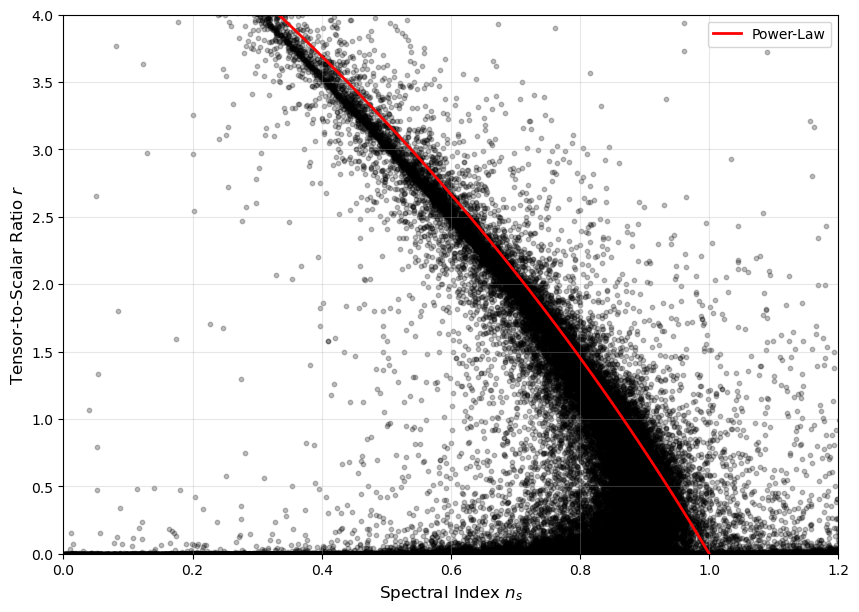

In [30]:
plt.figure(figsize=(10, 7))
        
# Filter outliers for cleaner plot
mask = (r_vals < 10) & (ns_vals > 0.0) & (ns_vals < 2.0)

#thin = 10
        
#plt.scatter(ns_vals[mask][::thin], r_vals[mask][::thin], marker='o', s=10, c='black', alpha=0.25)
plt.scatter(ns_vals[mask], r_vals[mask], marker='o', s=10, c='black', alpha=0.25)        
# Reference Power-Law Line
r_line = np.linspace(1e-10, 4.0, 100)
ns_line = 1 - 2 * r_line / (16 - r_line)

plt.plot(ns_line, r_line, 'r-', lw=2, label='Power-Law')
plt.xlabel(r'Spectral Index $n_s$', fontsize=12)
plt.ylabel(r'Tensor-to-Scalar Ratio $r$', fontsize=12)
#plt.title(f'Inflationary Flow Reconstruction (M={M_ORDER})', fontsize=14)
#plt.yscale('log')
plt.xlim(0., 1.2)
plt.ylim(0,4)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('ns_r_M8_nolog.pdf',transparent=True, bbox_inches='tight') 

In [29]:
# Save the final results array to a binary file
np.save('inflation_flow_results_M8.npy', results)
print("Data saved to inflation_flow_results_M8.npy")

Data saved to inflation_flow_results_M8.npy
